#### I wanted to optimize when I tweet to make sure I get the most possible bang for my buck when I do. This notebook looks to answer the question "when should I tweet in order to get the most engagement" where the metric of engagement is favorites and retweets. Some other looks into my twitter usage is investigated as well.

In [1]:
# Get our libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
%matplotlib inline

### First import data of tweets since 2015. See python/get_data.py for how this was built.

In [2]:
df = pd.read_csv('../data/mytweets.csv',)
df['date_time'] = pd.to_datetime(df['created_at'])
df.head()

,created_at,favorite_count,retweet_count,date_time
0,Thu Jan 17 17:06:08 +0000 2019,6,0,2019-01-17 17:06:08
1,Thu Jan 17 15:26:07 +0000 2019,11,1,2019-01-17 15:26:07
2,Thu Jan 17 00:18:31 +0000 2019,67,3,2019-01-17 00:18:31
3,Wed Jan 16 14:30:00 +0000 2019,9,0,2019-01-16 14:30:00
4,Tue Jan 15 14:30:01 +0000 2019,9,0,2019-01-15 14:30:01


Quick add some extra info and index by datetime object

In [3]:
df['weekday'] = df.apply(lambda row: row.date_time.strftime('%A'),axis=1)
df['engagements'] = df.apply(lambda row: row.favorite_count + row.retweet_count ,axis=1)
df = df.set_index('date_time')
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

### First look at when I tweet

In [4]:
df['weekday'].value_counts()

Thursday     290
Friday       279
Wednesday    278
Monday       266
Tuesday      255
Saturday     195
Sunday       174
Name: weekday, dtype: int64

Graphically...

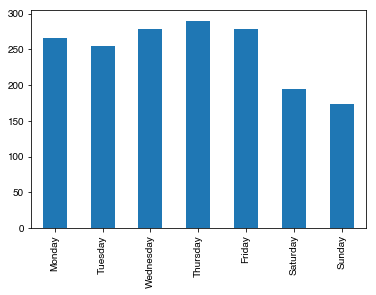

In [5]:
df['weekday'].value_counts().reindex(days).plot(kind='bar')

Strong difference in weekend vs weekdays, but pretty similar within the two categories

### Start looking at engagements (RT+favs) for the tweets

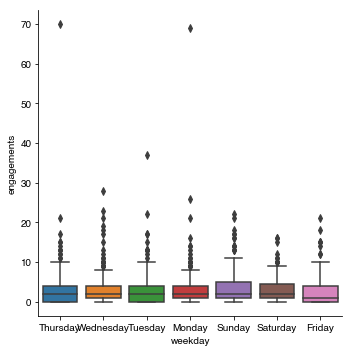

In [6]:
sns.catplot(x="weekday", y="engagements", kind="box", data=df);

Two huge outliers, I guess randomly more successful tweets. To focus on the larger trend, I'll kill those by cutting everything outside 30 engagements

In [7]:
base_df = df[df["engagements"] < 30]

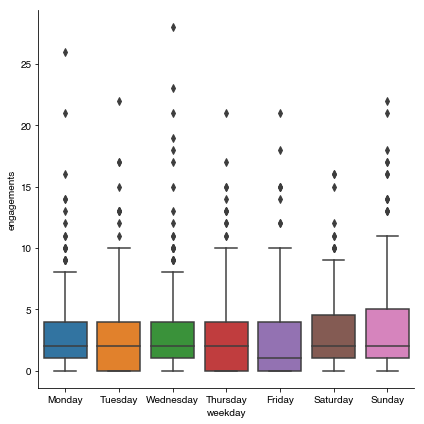

In [8]:
sns.catplot(x="weekday", y="engagements", kind="box", data=base_df, order=days, height=6)

Quick look at time series data, although it's going to be super noisy and not worthwhile, since it'll be over the whole timerange

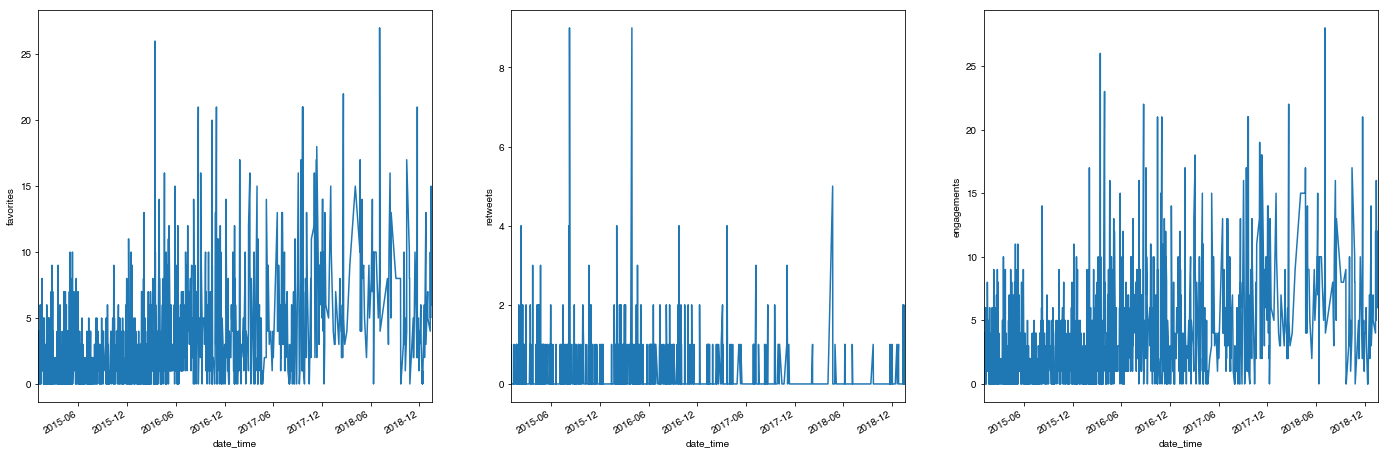

In [9]:
fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
base_df.favorite_count.plot(ax=ax1); ax1.set_ylabel('favorites')
base_df.retweet_count.plot(ax=ax2); ax2.set_ylabel('retweets')
base_df.engagements.plot(ax=ax3); ax3.set_ylabel('engagements')

Let's try just looking at one day of the week too...

In [10]:
daily_dfs = {}
for day in days:
    daily_dfs[day] = base_df[base_df['weekday']==day]

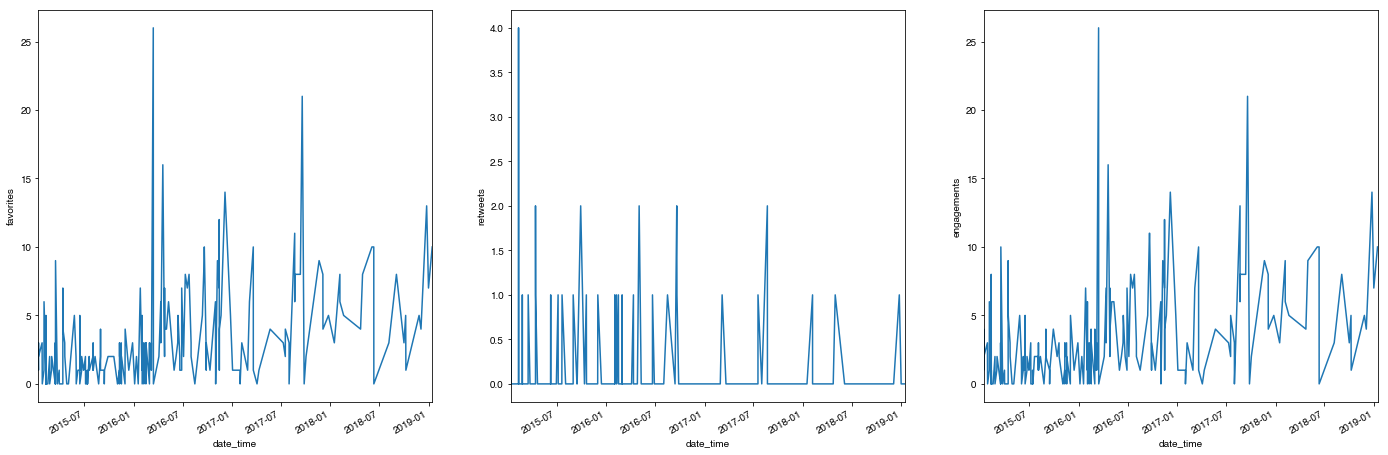

In [11]:
fig2, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,8))
daily_dfs['Monday'].favorite_count.plot(ax=ax1); ax1.set_ylabel('favorites')
daily_dfs['Monday'].retweet_count.plot(ax=ax2); ax2.set_ylabel('retweets')
daily_dfs['Monday'].engagements.plot(ax=ax3); ax3.set_ylabel('engagements')

### Getting down to the real question - when have my tweets gotten the most engagement
To solve this, I'll plot engagements vs time, binned by hour

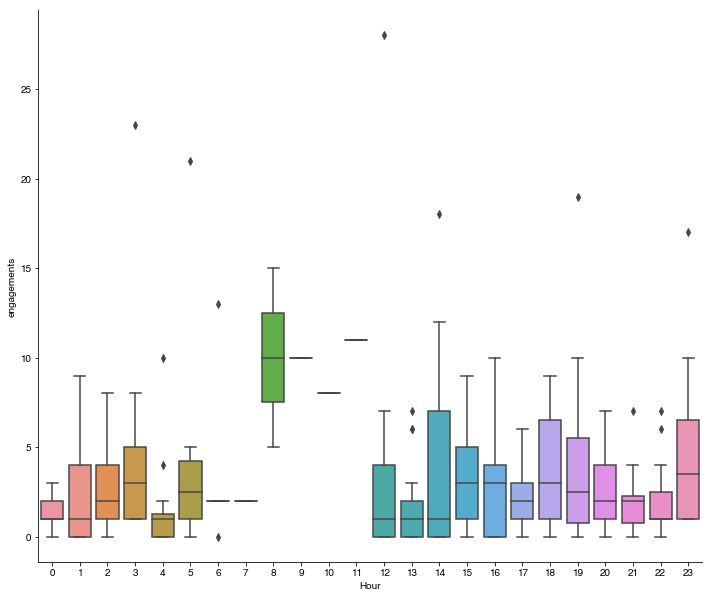

In [12]:
sns.catplot(x=daily_dfs['Wednesday'].index.hour ,y='engagements', kind='box', data=daily_dfs['Wednesday'], height= 10)
plt.gca().set(xlabel='Hour')

#### I really don't think there's enough stats on any single day here to get a good feel. Many outliers, only a couple of tweets for a few hours. Move to weekend/weekday splits

In [13]:
base_df['num_day'] = base_df.index.to_series().apply(lambda x: x.weekday())
weekday_df = base_df[base_df['num_day'] < 5 ]
weekend_df = base_df[base_df['num_day'] >= 5 ]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Check that worked...

In [14]:
weekday_df['weekday'].value_counts()

Thursday     289
Friday       279
Wednesday    278
Monday       265
Tuesday      254
Name: weekday, dtype: int64

In [15]:
weekend_df['weekday'].value_counts()

Saturday    195
Sunday      174
Name: weekday, dtype: int64

In [16]:
weekday_tweets = weekday_df['weekday'].value_counts().sum()
weekend_tweets = weekend_df['weekday'].value_counts().sum()
print "Weekdays tweets: %i \nWeekend tweets: %i \nRatio %.2f" %(weekday_tweets, weekend_tweets, float(weekday_tweets)/weekend_tweets)

Weekdays tweets: 1365 
Weekend tweets: 369 
Ratio 3.70


Working with pretty low stats still for the weekends. I am curious how more often I tweet on weekdays than weekends...

In [17]:
avg_weekday_tweets = weekday_tweets/5
avg_weekend_tweets = weekend_tweets/2
print "Avg weekdays tweets: %.1f \nAvg weekend tweets: %.1f \nRatio %.2f" %(avg_weekday_tweets, avg_weekend_tweets, float(avg_weekday_tweets)/avg_weekend_tweets)

Avg weekdays tweets: 273.0 
Avg weekend tweets: 184.0 
Ratio 1.48


### Now let's make the same plot for just weekdays.

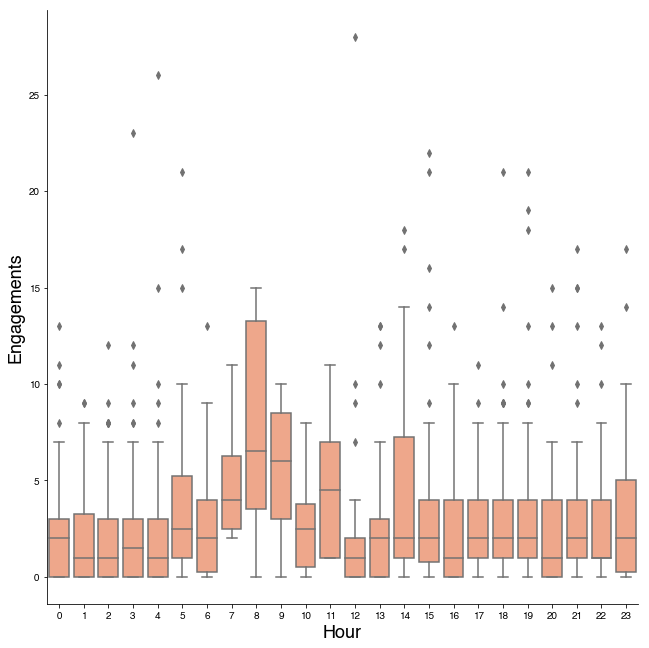

In [18]:
p_wd = sns.catplot(x=weekday_df.index.hour ,y='engagements', kind='box', data=weekday_df, height=9,color='lightsalmon')
plt.gca().set_ylabel('Engagements', fontsize=18)
plt.gca().set_xlabel('Hour', fontsize=18)

Nice - seems a lot more instructive. Now let's try weekends too.

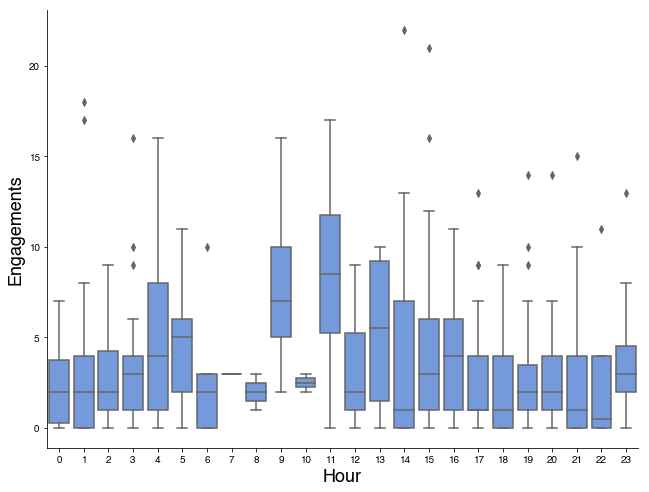

In [19]:
p_we = sns.catplot(x=weekend_df.index.hour ,y='engagements', kind='box',  data=weekend_df, height=9, color='cornflowerblue')
plt.gca().set_ylabel('Engagements', fontsize=18)
plt.gca().set_xlabel('Hour', fontsize=18)

Perfect, trends are somewhat visibile here. I'll make a big plot of them next to each other for comparison then make conclusions

### Okay, last I'll make this into one big finalized figure that I can show all at once

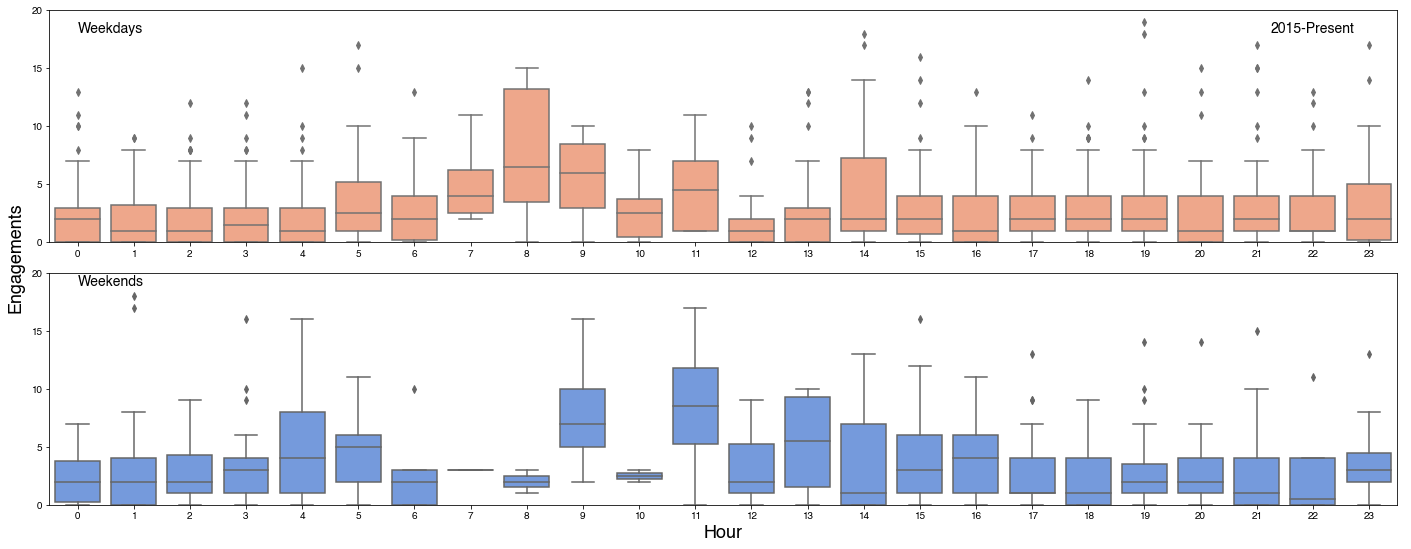

In [20]:
# Make mpl fig
f = plt.figure(figsize=(20,8))
shared_ax = f.add_subplot(111,frameon=False) # later used for y axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
axes1 = f.add_subplot(211) # weekday plot
axes2 = f.add_subplot(212) # weekend plt

# Remake the plots
p_wd = sns.catplot(x=weekday_df.index.hour ,y='engagements', kind='box', data=weekday_df, height=10,color='lightsalmon',ax=axes1)
plt.close(2) # gets rid of silly extra plot in jupyter
p_we = sns.catplot(x=weekend_df.index.hour ,y='engagements', kind='box',  data=weekend_df, height=10, color='cornflowerblue', ax=axes2)
plt.close(2)

# Make pretty
axes2.set_xlabel('Hour', fontsize=18)

# Stuff for bothaxes
for ax in [axes1,axes2]:
    ax.set_ylabel('', fontsize=18)
    ax.set_ylim(0,20)
    plt.sca(ax); plt.locator_params(axis='y', nbins=4)



plt.annotate(s='Weekdays',xy=(0.055,0.94), xycoords='figure fraction', ha='left',fontsize=14)
plt.annotate(s='Weekends',xy=(0.055,0.48), xycoords='figure fraction', ha='left',fontsize=14)
plt.annotate(s='2015-Present',xy=(0.96,0.94), xycoords='figure fraction', ha='right',fontsize=14)
shared_ax.set_ylabel('Engagements',fontsize=18)

plt.tight_layout()
plt.savefig('../plots/engagements.png')

## What did we learn?
1) If I want to tweet for most average engagements, on weekdays I should tweet between 8 and 9 am. Weekends are less clear due to low stats at 10, but 11 am and 1 pm seem like good times.

2) During the week, more upward outliers exist after noon. Between 2-3 or 7-8 om. This seems to imply I'd have a better chance of things getting shared and catching on at those hours. During the weekends, the 2-3 outliers are present too

3) I should wake up earlier on weekends. I don't have many stats at all for 7-8 or 10 am. Also I tweet 50% more on weekdays, as shown above

## Jan 17, 2019 - Update.
I want to quickly try to do a 15 minute rolling average for the time to see if that makes the datetime plots better

In [115]:
def resample_average_plot(df,axes):
    df['time'] = df.index.time
    resample_df = df.set_index('time')
    resample_df.index = pd.to_datetime(resample_df.index,format='%H:%M:%S')
    done_resample_df = resample_df.resample('45T')
    done_resample_df= done_resample_df.drop(['num_day'], axis=1)
    done_resample_df['engagements'].plot(ax=axes,figsize=(10,3))
    

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.resample() is now a deferred operation
You called drop(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


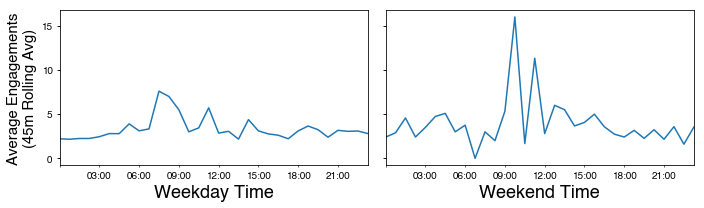

In [116]:
f, (axes1,axes2) = plt.subplots(nrows=1, ncols=2, sharey=True)

resample_average_plot(weekday_df,axes1)
resample_average_plot(weekend_df,axes2)

# both axes
for ax in [axes1,axes2]:
    plt.sca(ax)
    plt.gca().xaxis.set_major_locator(dates.HourLocator())
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))

# ax1
axes1.set_xlabel('Weekday Time', fontsize=18)
axes1.set_ylabel('Average Engagements\n(45m Rolling Avg)', fontsize=15)

# ax2
axes2.set_xlabel('Weekend Time', fontsize=18)
plt.tight_layout()
plt.savefig('../plots/resample_average.png')


In [170]:
def rolling_average_plot(df,axes):
    df = df.set_index('time')
    df = df.sort_index()
    df.index = pd.to_datetime(df.index,format='%H:%M:%S')
    df_resamp = df.resample('45T').mean()
    df_roll = df_resamp[['engagements']].rolling(5, center=True,min_periods=1).mean()
    df_roll['engagements'].plot(ax=axes,figsize=(10,4))        

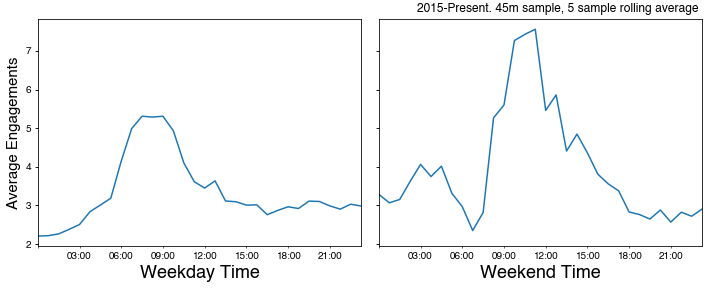

In [175]:
f, (axes1,axes2) = plt.subplots(nrows=1, ncols=2, sharey=True)

for ax in [axes1,axes2]:
    ax.xaxis_date()

rolling_average_plot(weekday_df,axes1)
rolling_average_plot(weekend_df,axes2)

# both axes
for ax in [axes1,axes2]:
    plt.sca(ax)
    plt.gca().xaxis.set_major_locator(dates.HourLocator())
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    
# ax1
axes1.set_xlabel('Weekday Time', fontsize=18)
axes1.set_ylabel('Average Engagements', fontsize=15)

# ax2
axes2.set_xlabel('Weekend Time', fontsize=18)

plt.annotate(s='2015-Present. 45m sample, 5 sample rolling average',xy=(0.98, 0.96), xycoords='figure fraction', ha='right',fontsize=12)


plt.tight_layout()
plt.savefig('../plots/rolling_average.png')